In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.sparse as sp
import sknetwork as sn

import vector_processing
import rankbasedlinkage as rbl

import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

In [3]:
data = np.load("clusterable_data.npy")
data.shape

(2309, 2)

# Do HDBSCAN Style Cluster Selection from RBL tree

In [4]:
rank_graph = vector_processing.build_knn_rank_graph(data, n_neighbors=20)
linkage = rbl.RankBasedLinkage().fit(rank_graph)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Making Friend List


100%|██████████| 2309/2309 [00:00<00:00, 5344.10it/s]


Compute In Sway


100%|██████████| 17015/17015 [00:02<00:00, 6778.67it/s]

Done


In [5]:
linkage_distances = linkage.linkage.copy()
linkage_distances.data = np.max(linkage_distances.data) + 1 - linkage_distances.data

In [6]:
tree = sp.csgraph.minimum_spanning_tree(linkage_distances)
x, y = tree.nonzero()
min_spanning_tree = np.stack([x, y, tree.data], dtype="float64").transpose()

# Sort edges of the min_spanning_tree by weight
min_spanning_tree = min_spanning_tree[np.argsort(min_spanning_tree.T[2]), :]

In [7]:
np.max(sn.topology.get_connected_components(min_spanning_tree))

np.int32(0)

<Axes: >

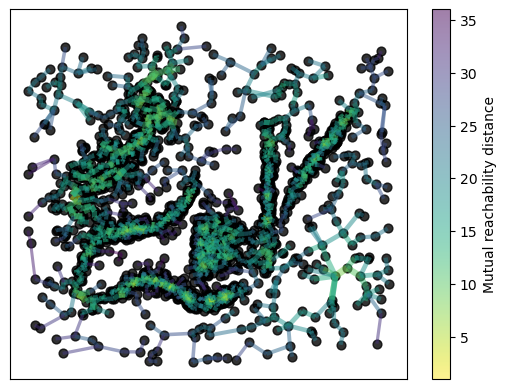

In [8]:
rbl_tree = hdbscan.plots.MinimumSpanningTree(min_spanning_tree, data)
rbl_tree.plot()

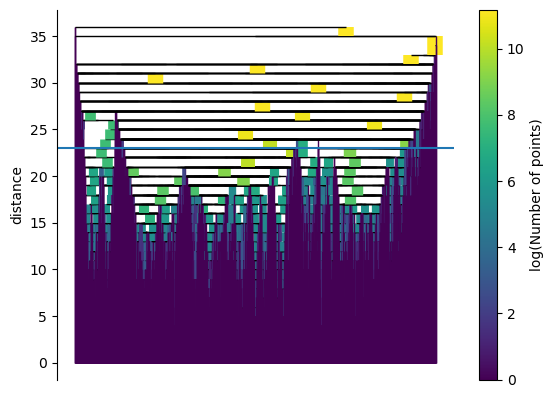

In [9]:
single_linkage_tree = hdbscan._hdbscan_linkage.label(min_spanning_tree)
as_tree = hdbscan.plots.SingleLinkageTree(single_linkage_tree)
ax = as_tree.plot()
# Get critical suggested T
T = 0
while np.sum(linkage.linkage.data >= T)/2 >= linkage.linkage.shape[0]:
    T += 1
ax.axhline(T)

<Axes: ylabel='$\\lambda$ value'>

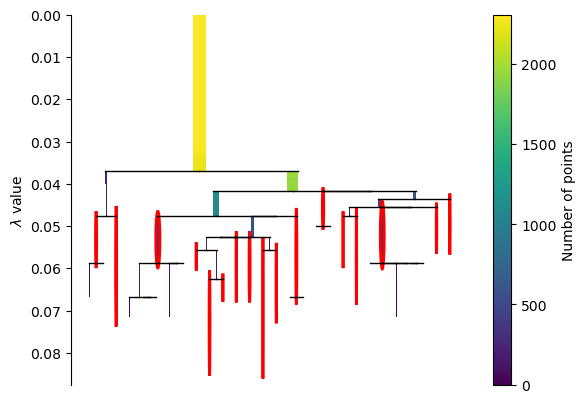

In [10]:
min_cluster_size=25
cluster_selection_method="eom"

condensed_tree = hdbscan._hdbscan_tree.condense_tree(single_linkage_tree, min_cluster_size)

cdt = hdbscan.plots.CondensedTree(condensed_tree, cluster_selection_method=cluster_selection_method)
cdt.plot(select_clusters=True, selection_palette=sns.color_palette())

17  clusters found!


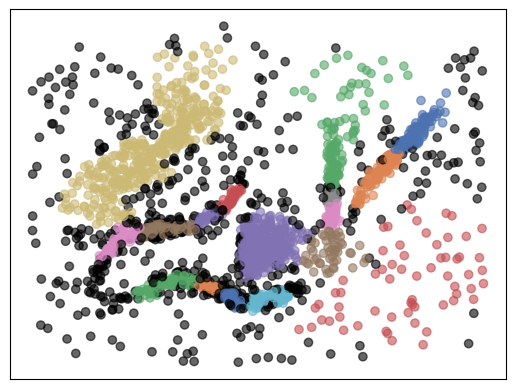

In [11]:
stability_dict = hdbscan._hdbscan_tree.compute_stability(condensed_tree)
predict, probabilities, stabilities = hdbscan._hdbscan_tree.get_clusters(
    condensed_tree,
    stability_dict,
    cluster_selection_method=cluster_selection_method,
    )

print(np.max(predict)+1, " clusters found!")

palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
plt.scatter(data.T[0], data.T[1], c=colors, alpha=0.6)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

22  clusters found!


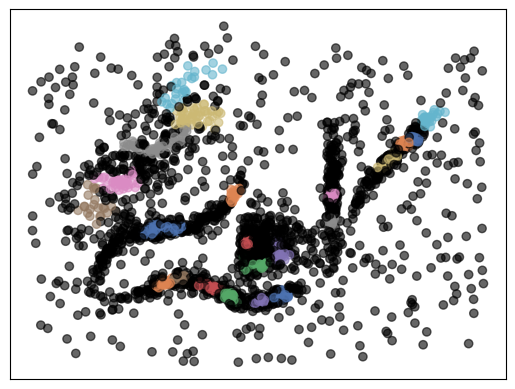

In [19]:
# Show suggest starting place results
predict = linkage.predict()
print(np.max(predict)+1, " clusters found!")

palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
plt.scatter(data.T[0], data.T[1], c=colors, alpha=0.6)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

# Same Plots with the normal HDBSCAN Algorithm

In [12]:
clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True, min_cluster_size=25)
clusterer.fit(data)

HDBSCAN(gen_min_span_tree=True, min_cluster_size=25)

<Axes: >

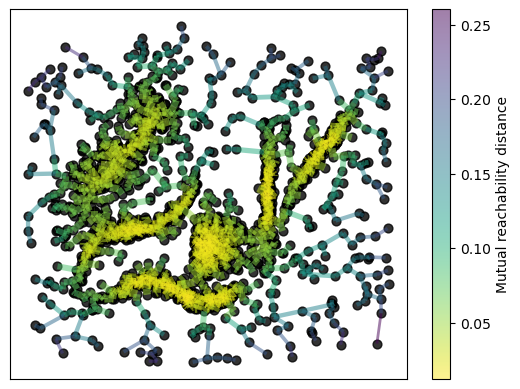

In [13]:
clusterer.minimum_spanning_tree_.plot()

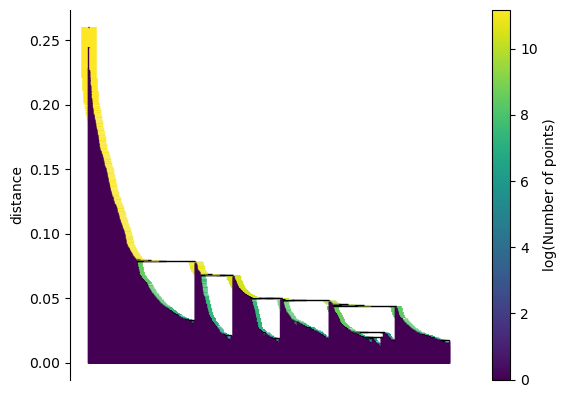

In [14]:
ax = clusterer.single_linkage_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

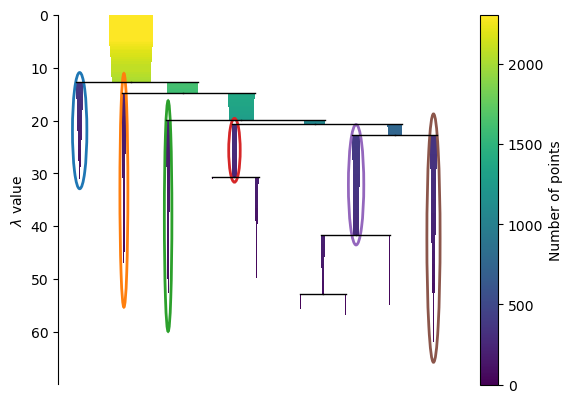

In [15]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

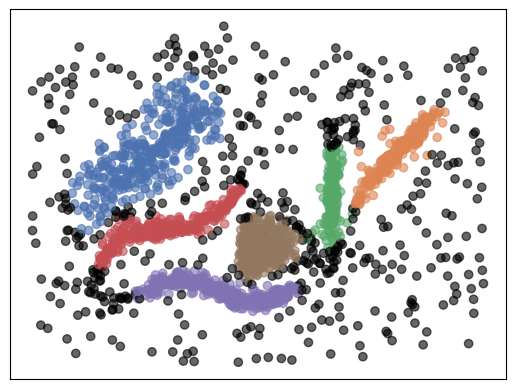

In [16]:
predict = clusterer.labels_
palette = sns.color_palette("deep", np.unique(predict).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in predict]
plt.scatter(data.T[0], data.T[1], c=colors, alpha=0.6)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)